### Import

In [9]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *
from sympy import lambdify

### Parameters

In [1]:
N = 5                  # number of states in charge basis: -N...N
ν_ge = 5.5223             # atom frequency, GHz
Ec = 0.2
Ej = (ν_ge-Ec)**2/Ec/8  # see Koch's paper for the approximation of the ge transition frequency
Ej_fixed = (ν_ge+0.4-Ec)**2/Ec/8
Ej = Ej_fixed
dE_ghz = 2.5
dEj = dE_ghz/ν_ge              #Ej(t) = Ej*time_coeff(t,dEj)
t1 = 10               #approximate start of Ej change
t_gate = 35
t2 = t1 + t_gate                 #approximate end of Ej change
stretch = 2            #stretch -> 0, time_coeff -> theta(t-t1) - theta(t-t2)
dEj2 = 0              #try to correct state
time_coeff = "1"+"-0.5*dEj*(tanh((t-%f-t1)/stretch) - tanh((t-%f-t2)/stretch))"%(0,0)
args = {'t1':t1,'t2':t2,'stretch':stretch,'dEj':dEj,'dEj2':dEj2}
tlist = np.linspace(0,3100,1000)
gamma_m = 0.001          #collapse rate
time_correction_coeff = "+ 0.5*dEj2*(tanh((t-1.2*t2)/stretch) - tanh((t-1.2*t2-0.2*(t2-t1))))"
#time_coeff += time_correction_coeff
#extra_time = "-0.5*dEj*(tanh((t-t1 - (t2-t1)*2)/stretch) - tanh((t-t2- (t2-t1)*2)/stretch))"
#extra_time += "-0.5*dEj*(tanh((t-t1 - (t2-t1)*4)/stretch) - tanh((t-t2- (t2-t1)*4)/stretch))"
#time_coeff += extra_time
#psi0                    #-> evecs[0]

time_coeff_list = []
dt = 60
time_coeff = "1"
for i in range(50):
    time_coeff_list.append("-0.5*dEj*(tanh((t-%f-t1)/stretch) - tanh((t-%f-t2)/stretch))"%(i*dt,i*dt))
    time_coeff += time_coeff_list[-1]
print(time_coeff)    

NameError: name 'np' is not defined

### Visualize pulse

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


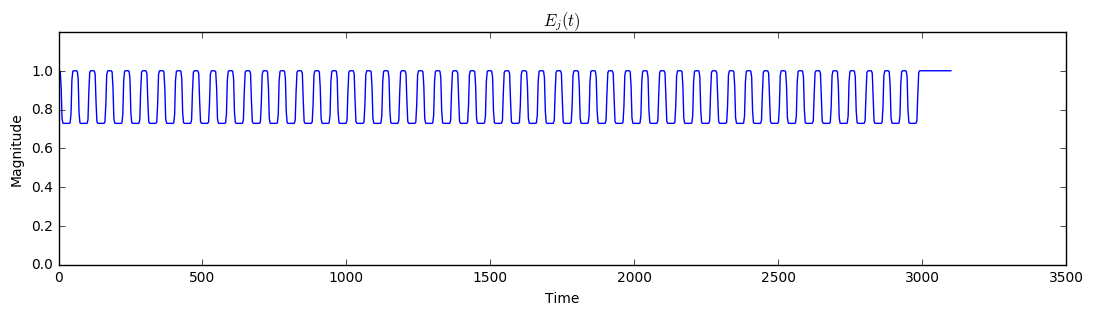

In [42]:
time_c_func = lambdify({'t1','t2','stretch','dEj','t','dEj2'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(t1=t1,t2=t2,dEj=dEj,dEj2 = dEj2,stretch=stretch,t=tlist))
ax.set_ylim(0,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


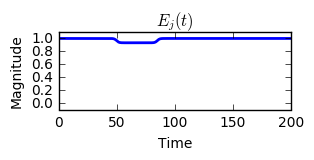

In [12]:
time_c_func = lambdify({'t1','t2','stretch','dEj','t','dEj2'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(3,1),dpi=600)
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(t1=t1,t2=t2,dEj=dEj,dEj2 = dEj2,stretch=stretch,t=tlist),linewidth=2)
ax.set_ylim(-0.1,1.1)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

### Operators

In [56]:
def n(N_states):
    return num(2*N_states+1, offset = -N_states)

def Hc(N_states = N, n_g = 0, Ec = Ec):
    return 4*Ec*(n(N_states)-n_g)**2

def Hj(N_states = N, Ej = Ej):
    return -0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))

def Hq(N_states = N, Ej = Ej, Ec = Ec):
    return Hc(N_states,Ec) + Hj(N_states,Ej)

def Hq_t(N_states = N,time_coeff = time_coeff, Ej = Ej, Ec = Ec):
    return [Hc(N_states, Ec),[Hj(N_states,Ej), time_coeff]]

evals, evecs = Hq(N,Ej-dE_ghz).eigenstates()
new_f = evals[1]-evals[0]
print(new_f)
evals, evecs = Hq().eigenstates()
psi0 = evecs[0]
print((evals[1]-evals[0]))
print((evals[1]-evals[0])-new_f)

def c(N_states=N,evecs=evecs, Ej = Ej, Ec = Ec):
    return sum([n(N).matrix_element(evecs[j], evecs[j+1])/n(N).matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

def collapse_list(N_states = N,gamma_m = gamma_m):
    collapse_list = []
    collapse_list.append(np.sqrt(gamma_m) * c())
    return collapse_list

5.16188472364
5.53010928539
0.368224561748


### Dynamics (sample)

In [6]:
expected = [Hq()]
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [52]:
expected = [Hq()]
for i in range(len(evecs)):
    expected.append(evecs[i]*evecs[i].dag())
    
output = solve(expected)

10.0%. Run time:   1.82s. Est. time left: 00:00:00:16
20.0%. Run time:   5.85s. Est. time left: 00:00:00:23
30.0%. Run time:   8.61s. Est. time left: 00:00:00:20
40.0%. Run time:  10.96s. Est. time left: 00:00:00:16
50.0%. Run time:  13.43s. Est. time left: 00:00:00:13
60.0%. Run time:  15.87s. Est. time left: 00:00:00:10
70.0%. Run time:  18.25s. Est. time left: 00:00:00:07
80.0%. Run time:  20.70s. Est. time left: 00:00:00:05
90.0%. Run time:  23.07s. Est. time left: 00:00:00:02
Total run time:  25.45s


### Visual

0.976737790376
0.989623720761
0.0102070538663
0.000138327837242


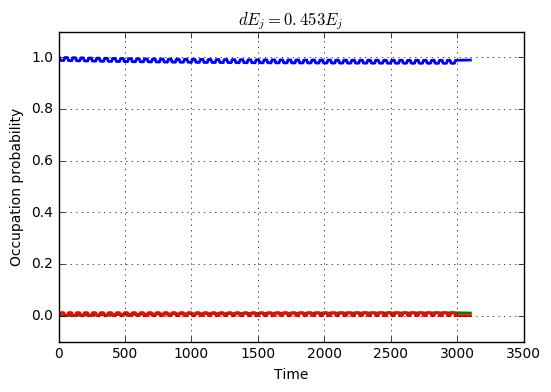

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=600)
ax.set_title('$dE_j = %.3f E_j$'%args['dEj']);
print(min(output.expect[1]))
for idx in range(3):
    ax.plot(tlist, output.expect[1+idx] ,linewidth=2,label=str(idx))#, label="Transmon %i state"%idx)
    ax.set_ylim(-0.1,1.1)
    print(output.expect[1+idx][-1])
ax.grid()
#ax.legend(bbox_to_anchor=[0.5,0.7])
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')


0.8083324502
0.962692790026
0.0342549206165
0.00110075713479
0.00140096313131
0.000406017315545
0.000104780388012
2.00650911839e-05


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


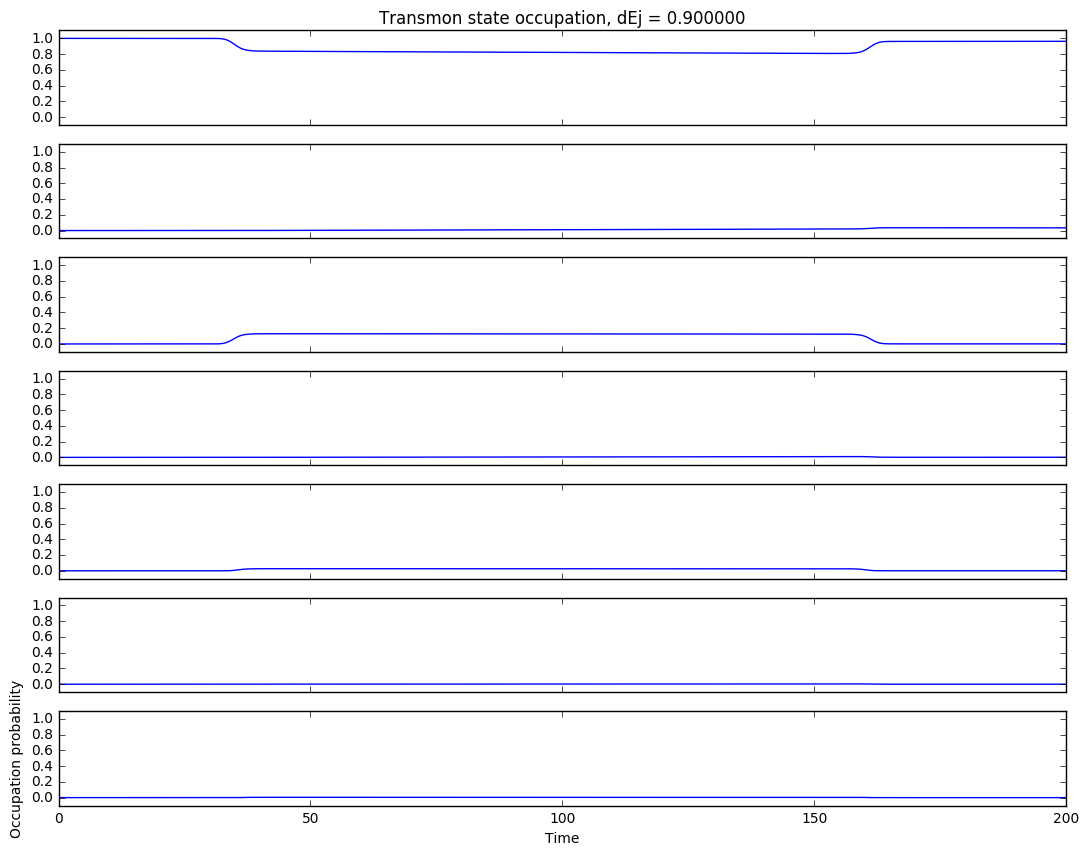

In [13]:
fig, axes = plt.subplots(7,1, figsize=(13,10), sharex=True)
axes[0].set_title('Transmon state occupation, dEj = %f'%args['dEj']);
print(min(output.expect[1]))
for idx, ax in enumerate(axes):
    ax.plot(tlist, output.expect[1+idx])#, label="Transmon %i state"%idx)
    ax.set_ylim(-0.1,1.1)
    ax.legend()
    print(output.expect[1+idx][-1])
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')


### Dynamics (series for dEj)

In [27]:
%%time
start_dEj = 0.4
end_dEj   = 0.5
steps_dEj = 10
tlist = np.linspace(0,200,400)
output = []
expected = [evecs[0]*evecs[0].dag()]
for dEj_id, dEj in enumerate(np.linspace(start_dEj, end_dEj, steps_dEj)):
    args['dEj'] = dEj
    output.append([solve(expected, False).expect[0],dEj])
    print('solved %d of %d\n' % (dEj_id+1,steps_dEj))

    

solved 1 of 10

solved 2 of 10

solved 3 of 10

solved 4 of 10

solved 5 of 10

solved 6 of 10

solved 7 of 10

solved 8 of 10

solved 9 of 10

solved 10 of 10

CPU times: user 36.7 s, sys: 424 ms, total: 37.1 s
Wall time: 59.2 s


### Visual

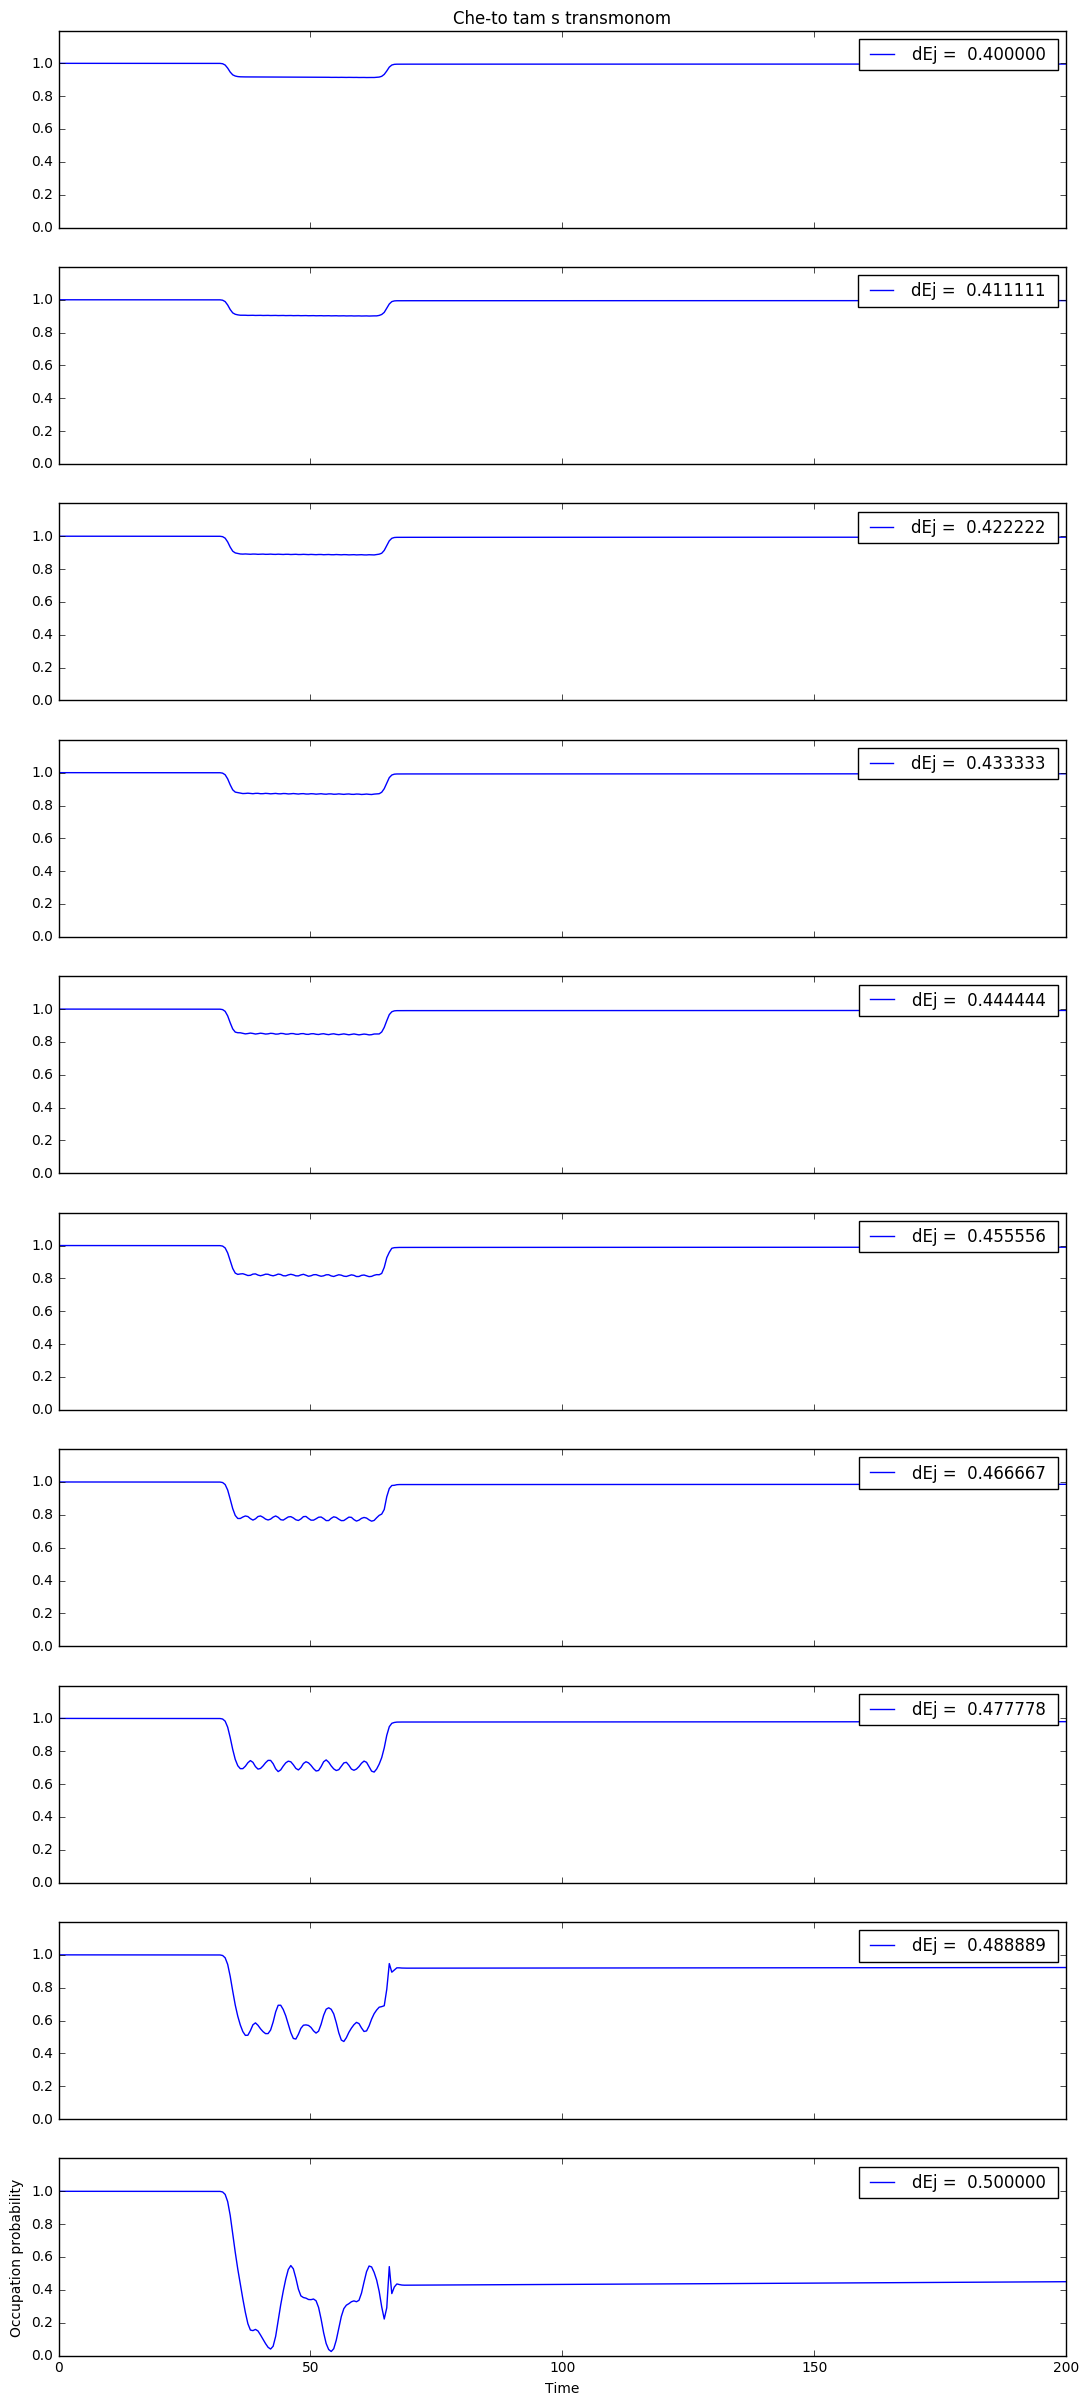

In [28]:
graphs = steps_dEj
maxgraphs = graphs
fig, axes = plt.subplots(graphs,1, figsize=(13,3*graphs), sharex=True)
axes[0].set_title('Che-to tam s transmonom');
for idx, ax in enumerate(axes):
    time_out, dEj = output[idx]
    ax.plot(tlist, time_out, label="dEj =  %f "%dEj)
    ax.set_ylim(0,1.2)
    ax.legend()
    if idx >= maxgraphs:
        break
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')

### Dynamics (series for t2)

In [31]:
%%time
start_t2 = 66
end_t2   = 68
steps_t2 = 10
tlist = np.linspace(0,200,400)
output = []
expected = [evecs[0]*evecs[0].dag()]
t2_list = np.linspace(start_t2, end_t2, steps_t2)
dEj = 0.47
for t2_id, t2_tmp in enumerate(t2_list):
    args['t2'] = t2_tmp
    args['dEj'] = dEj
    output.append([solve(expected, False).expect[0],t2_tmp])
    print('solved %d of %d\n' % (t2_id+1,steps_t2))

solved 1 of 10

solved 2 of 10

solved 3 of 10

solved 4 of 10

solved 5 of 10

solved 6 of 10

solved 7 of 10

solved 8 of 10

solved 9 of 10

solved 10 of 10

CPU times: user 28.9 s, sys: 380 ms, total: 29.3 s
Wall time: 51 s


### Visual

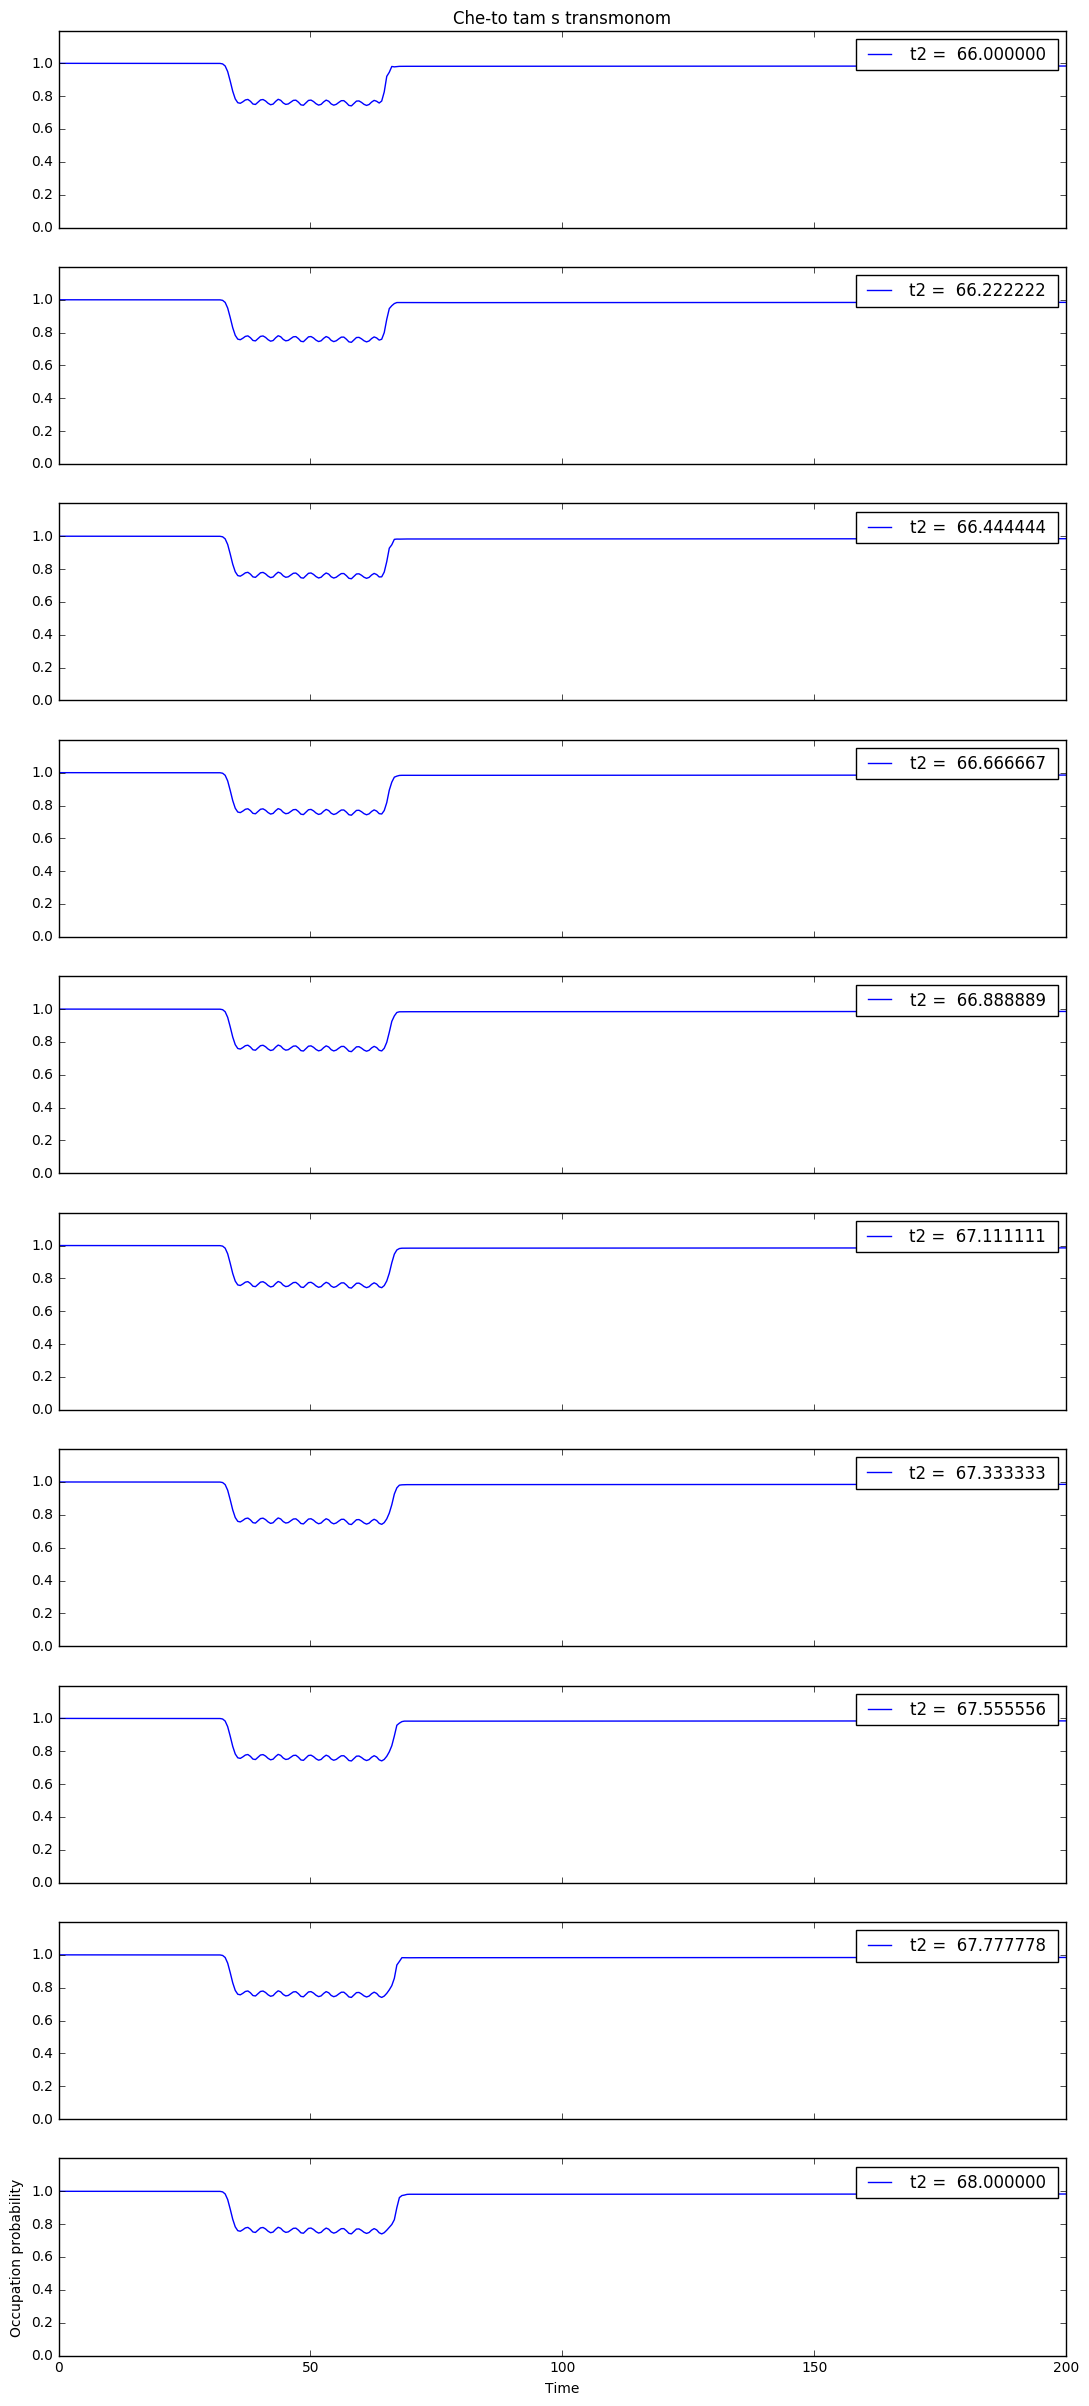

In [32]:
graphs = steps_t2
maxgraphs = graphs
fig, axes = plt.subplots(graphs,1, figsize=(13,3*graphs), sharex=True)
axes[0].set_title('Che-to tam s transmonom');
for idx, ax in enumerate(axes):
    time_out, t2 = output[idx]
    ax.plot(tlist, time_out, label="t2 =  %f "%t2)
    ax.set_ylim(0,1.2)
    ax.legend()
    if idx >= maxgraphs:
        break
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')

### Ground state occupation(+inf) <- dEj ?

In [48]:
def compressed_check(cont, every_percent):
    step = 1
    while True:
        yield step*len(cont)/100.0*every_percent
        step = step + 1

In [49]:
%%time
start_dEj = 0.9
end_dEj   = 0.999
steps_dEj = 100
dEj_list = np.linspace(start_dEj, end_dEj, steps_dEj)
tlist = np.linspace(0,200,40)
output = []
expected = [evecs[0]*evecs[0].dag()]
check = compressed_check(dEj_list,10)
print_id = next(check)
for dEj_id, dEj in enumerate(dEj_list):
    args['dEj'] = dEj
    output.append(solve(expected, False).expect[0])
    if(dEj_id+1 >= print_id):
        print('solved %d of %d\n' % (dEj_id+1,steps_dEj))
        print_id = next(check)
    

solved 10 of 100

solved 20 of 100

solved 30 of 100

solved 40 of 100

solved 50 of 100

solved 60 of 100

solved 70 of 100

solved 80 of 100

solved 90 of 100

solved 100 of 100

CPU times: user 4min 20s, sys: 4.14 s, total: 4min 24s
Wall time: 8min 6s


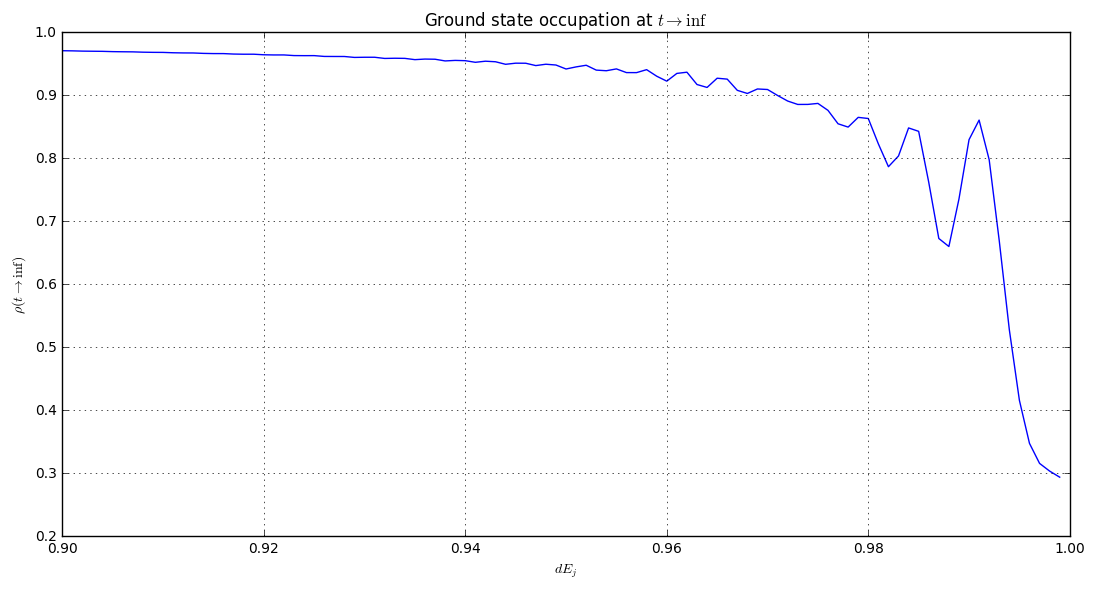

In [50]:
rho = list(map(lambda l:l[-1],output))
fig = plt.figure(figsize=(13,6.5),dpi=300)
dep = fig.add_subplot(1,1,1)
dep.set_title(r'Ground state occupation at $t \rightarrow \inf$')
dep.set_xlabel(r'$dE_j$')
dep.set_ylabel(r'$\rho(t \rightarrow \inf)$')
dep.plot(dEj_list,rho)
dep.grid()
#this is for t2-t1 = const !